# Задача: Сравнение методов классификации. Лямин Владимир Андреевич. Группа 22.М05
Задача
1. [+] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
2. [+] Взять данные для предсказания заболеваний сердца тут (целевой признак для предсказания --- target). Демо блакнот с анализом этих данных можно найти тут.
3. [+] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
4. [+] Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
5. [+] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
6. [+] Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
7. [+] Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
8. [+] Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.

Подключаем библиотеки

In [25]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Считываем данные

In [26]:
df = pd.read_csv('Data/heart.csv')

In [27]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Построение собственной модели Decision Tree

Импортируем библиотеки

In [28]:
# CART on the Bank Note dataset
from random import seed
from random import randrange
from csv import reader

accuracies = {}

Метод необходимы для кросс-валидации

In [29]:
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = dataset.values.tolist()
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

Метод, который подсчитывает точность измерений

In [53]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual))

Метод, который запускает обучение и тестирование алгоритма

In [31]:
def evaluate_algorithm(dataset, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = decision_tree(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

Функция, которая разделяет данные

In [32]:
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

Подсчет gini значения, которое поможет разделить данные наилучшим образом.

In [33]:
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

Выбирает наилучшее разделение для данных

In [34]:
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [35]:
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

Создает ребенка или терминальный узел

In [36]:
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

Функция, которая строит дерево

In [37]:
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

Функции, которые нужны для предсказания по готовому дереву

In [38]:
def predict(row):
    return predict(tree, row)


def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

Функция, которая берет тестовую базу данных, разбивает ее, а затем получает предсказанные значения

In [39]:
def predictions(test):
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

Функция, которая запускает построение дерева решений

In [40]:
def decision_tree(train, test, max_depth, min_size):
    global tree
    tree = build_tree(train, max_depth, min_size)
    return predictions(test)

### Подбор параметров к дереву

In [43]:
optimal_max_depth = 0
optimal_min_size = 0
maxValue = 0
n_folds = 5
for max_depth in range(2, 10):
    for min_size in range(6, 15):
        scores = evaluate_algorithm(df, n_folds, max_depth, min_size)
        mean = sum(scores)/float(len(scores))
        if (mean > maxValue):
            optimal_max_depth = max_depth
            optimal_min_size = min_size
            maxValue = mean
print(optimal_max_depth)
print(optimal_min_size)

9
10


Посмотрим результат. Ориентируясь на первую задачу, возьмем количество фолдов равное 5.

In [55]:
seed(1)
# evaluate algorithm
global tree
n_folds = 5
max_depth = 9
min_size = 6
scores = evaluate_algorithm(df, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f' % (sum(scores)/float(len(scores))))

accuracies['My decision Tree'] = sum(scores)/float(len(scores))

Scores: [0.9804878048780488, 0.9707317073170731, 0.9707317073170731, 0.9902439024390244, 0.9707317073170731]
Mean Accuracy: 0.977


## Посмотрим на результат библиотечных функий

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
acc = lr.score(X_test_scaled, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.8052


### K-Nearest Neighbour

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)  # n_neighbors means k
knn.fit(X_train_scaled, y_train)
prediction = knn.predict(X_test_scaled)

print("{} NN Score: {:.4f}".format(3, knn.score(X_test_scaled, y_test)))

3 NN Score: 0.9351


### Support Vector Machine

In [49]:
from sklearn.svm import SVC

svm = SVC(random_state = 12)
svm.fit(X_train_scaled, y_train)

acc = svm.score(X_test_scaled, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.8896


### Naive Bayes Algorithm

In [50]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

acc = nb.score(X_test_scaled, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.8149


### Decision Tree Algorithm

In [51]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

acc = dtc.score(X_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.9708


## Сравнение моделей

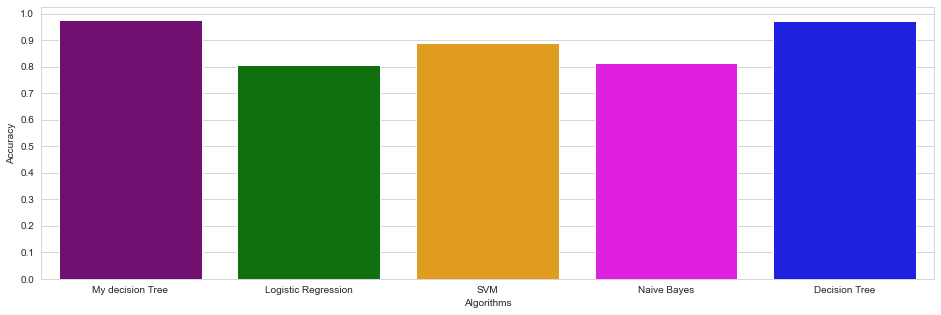

In [56]:
colors = ["purple", "green", "orange", "magenta", "blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

## Построение Confusion Matrix

In [57]:

y_head_lr = lr.predict(X_test_scaled)
knn3 = KNeighborsClassifier(n_neighbors = 1)
knn3.fit(X_train_scaled, y_train)
y_head_knn = knn3.predict(X_test_scaled)
y_head_svm = svm.predict(X_test_scaled)
y_head_nb = nb.predict(X_test_scaled)
y_head_dtc = dtc.predict(X_test)

y_head_Mydtc = predictions(X_test.values.tolist())

In [58]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)
cm_Mydtc = confusion_matrix(y_test, y_head_Mydtc)

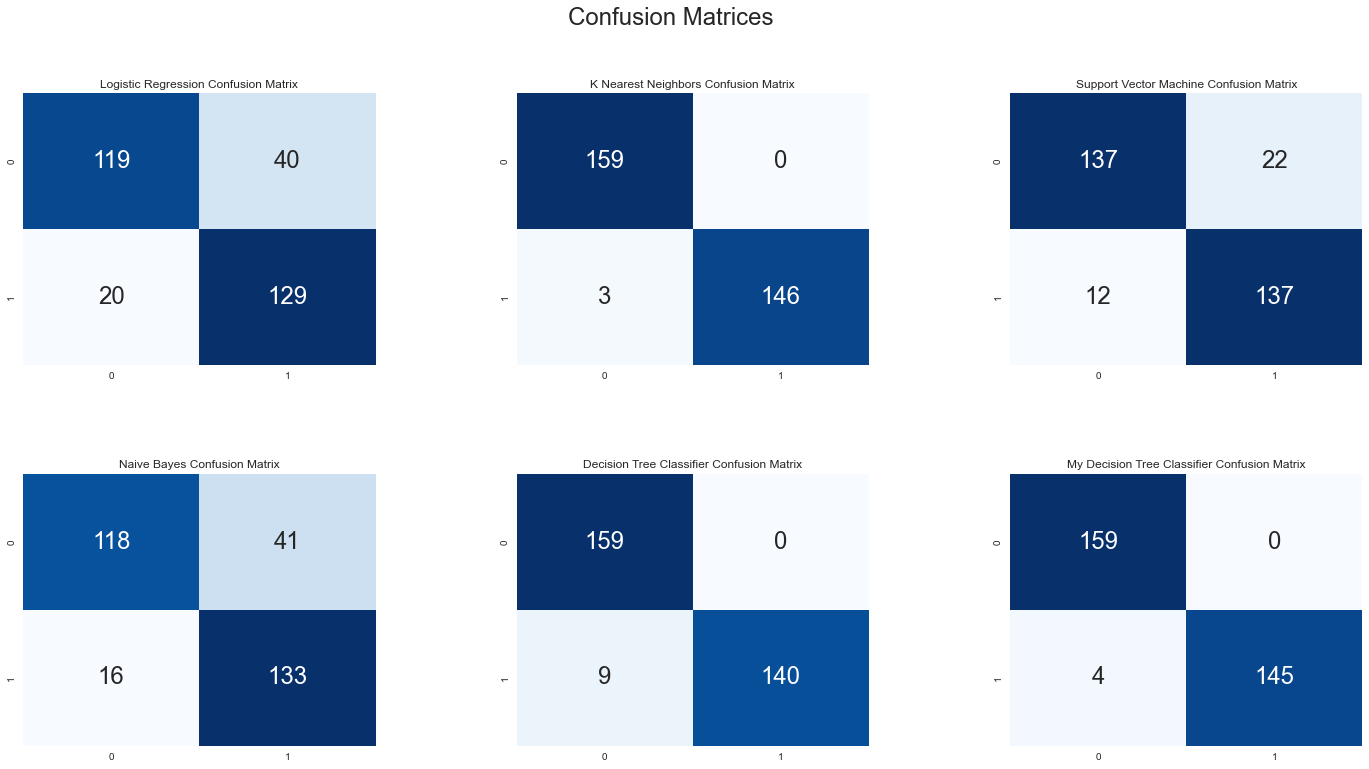

In [59]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("My Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_Mydtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

## Выводы

Можно увидеть, что наилучший результат дала библиотечная модель k ближайших соседей, моя модель дерева решений, а также библиотечная модель дерева решений. Плохие результаты дала модель логистической регрессии, а также наивный байесовский классификатор.